In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
#from skimage import io

In [2]:
annotations_file = 'annotations_imSize.csv'

In [3]:
anno = pd.read_csv(annotations_file)
anno.head()

,filename,x1,y1,x2,y2,class,Train/Test,width,height
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480
3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480
4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480


In [4]:
annos = anno[anno['width'] > 650] 
annos

,filename,x1,y1,x2,y2,class,Train/Test,width,height
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480
5,db_lisa_tiny/sample_006.png,476,137,514,174,stop,Train,704,480
6,db_lisa_tiny/sample_007.png,30,26,54,50,stop,Train,704,480
...,...,...,...,...,...,...,...,...,...
894,db_lisa_tiny/sample_895.png,567,29,593,60,speedLimit25,Train,704,480
895,db_lisa_tiny/sample_896.png,534,155,563,187,speedLimit25,Train,704,480
897,db_lisa_tiny/sample_898.png,633,236,663,269,speedLimit25,Train,704,480
898,db_lisa_tiny/sample_899.png,407,273,431,300,speedLimit25,Train,704,480


In [5]:
annos = annos.reset_index()
del annos["index"]

annos

,filename,x1,y1,x2,y2,class,Train/Test,width,height
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480
3,db_lisa_tiny/sample_006.png,476,137,514,174,stop,Train,704,480
4,db_lisa_tiny/sample_007.png,30,26,54,50,stop,Train,704,480
...,...,...,...,...,...,...,...,...,...
668,db_lisa_tiny/sample_895.png,567,29,593,60,speedLimit25,Train,704,480
669,db_lisa_tiny/sample_896.png,534,155,563,187,speedLimit25,Train,704,480
670,db_lisa_tiny/sample_898.png,633,236,663,269,speedLimit25,Train,704,480
671,db_lisa_tiny/sample_899.png,407,273,431,300,speedLimit25,Train,704,480


In [6]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [8]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Generates bounding box array from a anno row"""
    return np.array([x[2],x[1],x[4],x[3]])

In [9]:
# Create a column with bounding box values as a list type object
new_bbs = []

for index, row in annos.iterrows():
    new_bb = create_bb_array(row.values)
    new_bbs.append(new_bb)
    
annos['new_bb'] = new_bbs

In [10]:
annos.head()

,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_bb
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,"[40, 190, 63, 211]"
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,"[246, 4, 283, 43]"
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,"[286, 389, 314, 418]"
3,db_lisa_tiny/sample_006.png,476,137,514,174,stop,Train,704,480,"[137, 476, 174, 514]"
4,db_lisa_tiny/sample_007.png,30,26,54,50,stop,Train,704,480,"[26, 30, 50, 54]"


In [11]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [12]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [13]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.figure(figsize=(15,10))
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

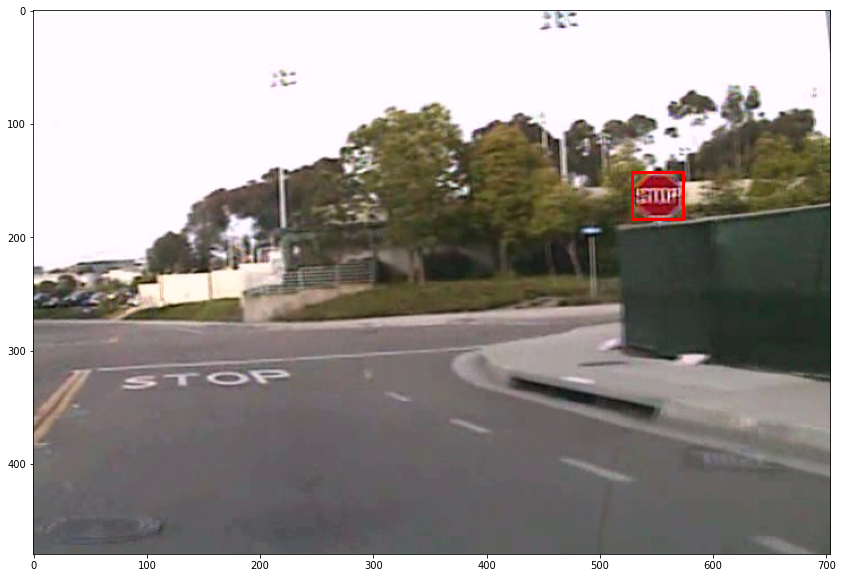

In [17]:
im_num = random.randint(0, 672)
im = cv2.imread(str(annos.values[im_num][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, annos.values[im_num][9])

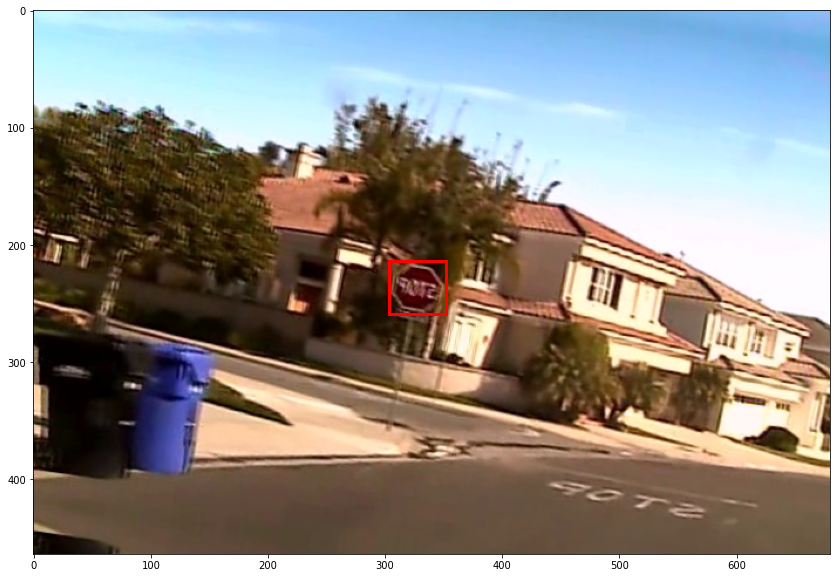

In [28]:
im, bb = transformsXY(str(annos.values[68][0]),annos.values[68][9],True )
show_corner_bb(im, bb)

In [24]:
unique = anno["class"].unique()
unique

array(['stop', 'yield', 'yieldAhead', 'merge', 'signalAhead',
       'pedestrianCrossing', 'keepRight', 'speedLimit35', 'speedLimit25'],
      dtype=object)

In [25]:
#Convert classes to dict and reverse key value pair
unique_enum = enumerate(unique)
unique_enum = dict(unique_enum)
unique_enum = {v: k for k, v in unique_enum.items()}
unique_enum

{'stop': 0,
 'yield': 1,
 'yieldAhead': 2,
 'merge': 3,
 'signalAhead': 4,
 'pedestrianCrossing': 5,
 'keepRight': 6,
 'speedLimit35': 7,
 'speedLimit25': 8}

In [30]:
# Create a column named Class Index
class_idx = []
for rows in annos["class"]:
    class_idx.append(unique_enum[rows])

annos["class_idx"] = class_idx

annos

,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_bb,class_idx
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,"[40, 190, 63, 211]",0
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,"[246, 4, 283, 43]",0
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,"[286, 389, 314, 418]",0
3,db_lisa_tiny/sample_006.png,476,137,514,174,stop,Train,704,480,"[137, 476, 174, 514]",0
4,db_lisa_tiny/sample_007.png,30,26,54,50,stop,Train,704,480,"[26, 30, 50, 54]",0
...,...,...,...,...,...,...,...,...,...,...,...
668,db_lisa_tiny/sample_895.png,567,29,593,60,speedLimit25,Train,704,480,"[29, 567, 60, 593]",8
669,db_lisa_tiny/sample_896.png,534,155,563,187,speedLimit25,Train,704,480,"[155, 534, 187, 563]",8
670,db_lisa_tiny/sample_898.png,633,236,663,269,speedLimit25,Train,704,480,"[236, 633, 269, 663]",8
671,db_lisa_tiny/sample_899.png,407,273,431,300,speedLimit25,Train,704,480,"[273, 407, 300, 431]",8


In [39]:
df_train = annos.reset_index()

In [41]:
df_train.head()

,index,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_bb,class_idx
0,0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,"[40, 190, 63, 211]",0
1,1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,"[246, 4, 283, 43]",0
2,2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,"[286, 389, 314, 418]",0
3,3,db_lisa_tiny/sample_006.png,476,137,514,174,stop,Train,704,480,"[137, 476, 174, 514]",0
4,4,db_lisa_tiny/sample_007.png,30,26,54,50,stop,Train,704,480,"[26, 30, 50, 54]",0


In [43]:
X = df_train[['filename', 'new_bb']]
Y = df_train['class_idx']

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [46]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [47]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [48]:
train_ds = RoadDataset(X_train['filename'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['filename'],X_val['new_bb'],y_val)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [50]:
batch_size = 10
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [51]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 9))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [52]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [53]:
from torch.autograd import Variable

In [54]:
# Declaring the loss function and optimizer
model = BB_model()
model = model.to(device)
print(model)

#criterion = # YOUR CODE HERE : Explore and declare loss function
# loss_fn = torch.nn.BCELoss()
loss_fn_classifier = torch.nn.CrossEntropyLoss(reduction="sum").to(device)

loss_fn_regressor = torch.nn.L1Loss(reduction="none").to(device)

#optimizer = # YOUR CODE HERE : Explore on optimizer and define with the learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

BB_model(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [55]:
#Train Function
def train(model, train_loader, optimizer, C=1000):
    model.train()
    total_loss = 0
    total_classes = 0
    correct_classes = 0

    for x, y_class, y_bb in train_loader:
        x = Variable(x.float())
        y_class = Variable(y_class)
        y_bb = Variable(y_bb.float())

        x, y_class, y_bb = x.to(device), y_class.to(device), y_bb.to(device)

        optimizer.zero_grad()

        out_class, out_bb = model(x)

        loss_class = loss_fn_classifier(out_class, y_class)


        loss_bb = loss_fn_regressor(out_bb, y_bb).sum(1)
        loss_bb = loss_bb.sum()

        loss = loss_class + loss_bb/C

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(out_class.data, 1)
        total_classes += y_class.size(0)
        correct_classes += (predicted == y_class).sum().item()
    return total_loss/len(train_loader.dataset), correct_classes/total_classes



#Validation Function
def validation(model, val_loader, C=1000):
    model.eval()
    total_loss = 0
    total_classes = 0
    correct_classes = 0
    with torch.no_grad():
        for x, y_class, y_bb in val_loader:
            x = Variable(x.float())
            y_class = Variable(y_class)
            y_bb = Variable(y_bb.float())

            x, y_class, y_bb = x.to(device), y_class.to(device), y_bb.to(device)


            out_class, out_bb = model(x)
            loss_class = loss_fn_classifier(out_class, y_class)

            loss_bb = loss_fn_regressor(out_bb, y_bb).sum(1)
            loss_bb = loss_bb.sum()

            loss = loss_class + loss_bb/C


            total_loss += loss.item()

            _, predicted = torch.max(out_class.data, 1)
            total_classes += y_class.size(0)
            correct_classes += (predicted == y_class).sum().item()
    
    return total_loss/len(val_loader.dataset), correct_classes/total_classes

In [57]:
#Training
train_losses = [] 
val_losses = []

num_epochs = 200

for epoch in range(1,num_epochs +1):
    # train network for 1 epoch
    train_loss, train_acc = train(model,train_dl, optimizer)

    # Validate the network on validation dataset
    val_loss, val_acc = validation(model, valid_dl)


    #log
    print('epoch [{}/{}], loss train:{:.6f} loss validation:{:.6f}, train accuracy:{:.6f}, validation accuracy:{:.6f}'
            .format(epoch, num_epochs, train_loss, val_loss, train_acc, val_acc))


    #Save Loss values
    train_losses.append(train_loss)
    val_losses.append(val_loss)

epoch [1/200], loss train:2.729412 loss validation:2.947883, train accuracy:0.498141, validation accuracy:0.503704
epoch [2/200], loss train:2.267681 loss validation:2.547733, train accuracy:0.579926, validation accuracy:0.614815
epoch [3/200], loss train:2.242817 loss validation:2.191964, train accuracy:0.592937, validation accuracy:0.637037
epoch [4/200], loss train:1.929934 loss validation:2.370999, train accuracy:0.680297, validation accuracy:0.600000
epoch [5/200], loss train:1.629285 loss validation:1.670195, train accuracy:0.747212, validation accuracy:0.785185
epoch [6/200], loss train:1.486736 loss validation:1.684997, train accuracy:0.765799, validation accuracy:0.718519
epoch [7/200], loss train:1.265302 loss validation:2.012895, train accuracy:0.804833, validation accuracy:0.651852
epoch [8/200], loss train:1.208692 loss validation:1.306961, train accuracy:0.778810, validation accuracy:0.740741
epoch [9/200], loss train:0.977282 loss validation:1.349822, train accuracy:0.82

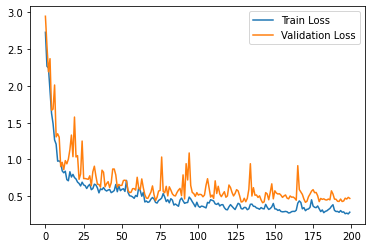

In [58]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()


In [84]:
im = read_image('db_lisa_tiny/sample_061.png')
cv2.imwrite('abcd.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'abcd.png'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]


xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 464, 680])

In [85]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 17.7184,  -2.1946,  -3.2584,  -3.3081, -10.0526,  -4.1348,   4.6770,
           -4.3371,  -2.0266]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 63.3928, 355.2732,  93.8212, 384.1989]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [86]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([17.7184], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

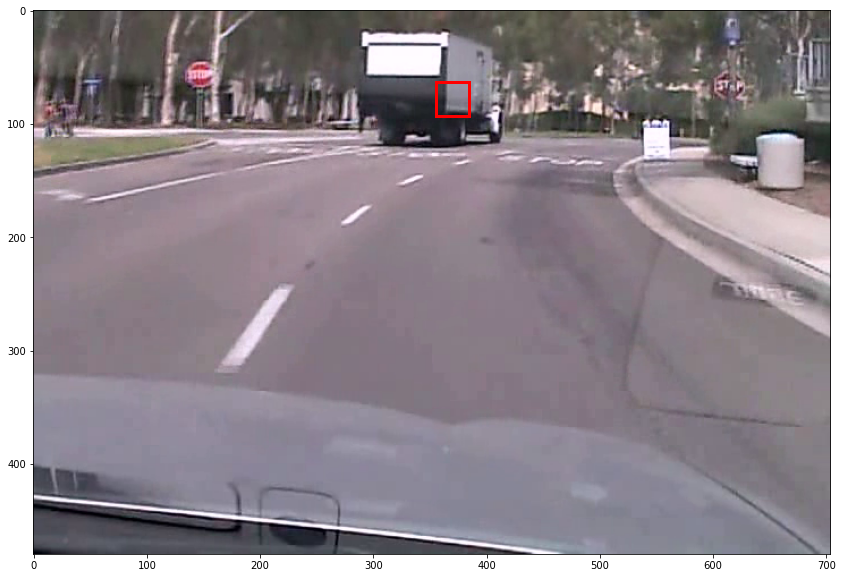

In [87]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)

show_corner_bb(im, bb_hat[0])